# Visualizing Convnets
Convolutional networks are not only great at viusla processing tasks, but allow som understanding of the inner workings of a trained network. As we will see here, we can probe units of convolutional networks an get some insight on what they are sensititve and get some insight about the hierarchichal processing carried out in deep neural nets.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tf_utils import ConvLayer, PoolLayer, FullyConnectedLayer
from vis_utils import tilePatches

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Receptive field
The receptive field is the area of the input image to which a particular unit (neuron) is sensitive.
In convolutional networks processing is localized spatially and behaviour replicates across space. This is expressed as a convolution. In their basic form, convolutional units are described by size and stride. The size is the effective window for which local computations are carried out. Stride is the relative displacement between two consecutive local computations. Receptive field are calculated based on the composition of these basic parameters through the layers of a convolutional network.

## Let's take a look at cifar10 dataset
Ww ahve gathered some experience with conve nets sing the MINST data set. In this case we will probe neurons from a network trained on a more naturalistic type of stimuli. Cifar 10 is a relatively simple data set described in https://www.cs.toronto.edu/~kriz/cifar.html. The number of training samples is similar to mnist but unlike mnist, cifar 10 contains 32 x 32 color images from 10 classes of objects.  

In [2]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict


def read_cifar(cifar_dir, one_hot=False, as_images=True):
        n_train = 50000
        n_test = 10000
        data_train = np.ndarray((n_train, 32*32*3), dtype=np.float32)
        data_test = np.ndarray((n_test, 32*32*3), dtype=np.float32)
        if one_hot is True:
            labels_train = np.zeros((n_train, 10), dtype=np.float32)
            labels_test = np.zeros((n_test, 10), dtype=np.float32)
        else:
            labels_train = np.ndarray(n_train, dtype=np.float32)
            labels_test = np.ndarray(n_test, dtype=np.float32)
        data_ptr = 0
        for iBtch in range(5):
            tmp_dict = unpickle(cifar_dir + "data_batch_%d"%(iBtch+1))
            data_train[data_ptr:data_ptr+tmp_dict['data'].shape[0], ::] = tmp_dict['data']
            if one_hot is True:
                for iSmp in range(data_ptr,data_ptr+len(tmp_dict['labels'])):
                    labels_train[iSmp, tmp_dict['labels'][iSmp - data_ptr]] = 1.0
            else:
                labels_train[data_ptr:data_ptr+len(tmp_dict['labels'])] = np.asarray(tmp_dict['labels'], dtype=labels_train.dtype)
            data_ptr += tmp_dict['data'].shape[0]
        
        tmp_dict = unpickle(cifar_dir + "test_batch")
        data_test = tmp_dict['data']
        if one_hot is True:
            for iSmp in range(n_test):
                labels_test[iSmp, tmp_dict['labels'][iSmp]] = 1.0
        else:
            labels_test = np.asarray(tmp_dict['labels'], dtype=labels_train.dtype)
        
        data_mean = np.mean(data_train, axis=0, keepdims=True)
        if as_images is True:
            data_train = np.transpose(np.reshape(data_train, [-1, 3, 32, 32]), [0, 2, 3, 1])
            data_test = np.transpose(np.reshape(data_test, [-1, 3, 32, 32]), [0, 2, 3, 1])
            data_mean = np.transpose(np.reshape(data_mean, [-1, 3, 32, 32]), [0, 2, 3, 1])
        return data_train, labels_train, data_test, labels_test, data_mean

data_train, labels_train, data_test, labels_test, data_mean = read_cifar("../data/cifar/cifar-10-batches-py/", one_hot=True, as_images=True)

## Digression warning! A little data handler
We will introduce our own data handler to retrieve minbatcehs for training

In [3]:
class Data(object):
    """
    Data class takes care of the minibatch management

    There are two optional parameters for Data objects.
    -- batch_size: if lefts as None will use the entire data set for 
       each pass.
    -- shuffle: wich defaults to true will shuffle data points to feed 
       the network at each iteration. When a epoch has been reached, 
       data is reshuffled.
    """
    batch_iter = None 
    data_size = None
    batch_idx = None
    crt_idx = None
    n_batches = None
    shuffle = None
    
    def __init__(self, data, batch_size=None, shuffle=True):
        self.data = data
        self.data_size = data.shape[0]
        self.shuffle = shuffle
        if batch_size is None:
            self.batch_size = self.data_size
            self.batch_iter = None
            self.batch_idx = None
            self.shuffle = False
        else:
            assert self.data_size >= batch_size, 'batch_size exeeds number of data samples'
            self.batch_size = batch_size
            self.batch_iter = 0
        self.n_batches = np.int64(self.data_size / self.batch_size)
        leftovers = self.data_size % self.batch_size
                
    def getBatch(self):
        if self.batch_iter is None:
            return self.data
  
        if self.batch_iter == 0:
            ## shuffle data at the begining of every epoch
            if self.shuffle is True:
                self.batch_idx = np.random.permutation(self.data_size)
            else:
                self.batch_idx = np.arange(self.data_size, dtype=np.int64)
            self.batch_idx = np.reshape(self.batch_idx, (self.n_batches, -1))
        self.crt_idx = self.batch_idx[self.batch_iter, :]
        batch = self.data[self.crt_idx, ::]
        self.batch_iter += 1
        if self.batch_iter == self.n_batches:
            self.batch_iter = 0
        return batch

    def getDataAsIn(self, ref_data_object=None):
        """
        This is an auxiliary method with the purpose of selecting
        the corresponding data-target pairs. 
        """
        if ref_data_object.crt_idx is not None:
            return self.data[ref_data_object.crt_idx, ::]
        else:
            return self.data

class CifarData(object):
    def __init__(self, data, labels, batch_size=None):
        self.data = Data(data, batch_size=batch_size)
        self.labels = Data(labels)
    
    def next_batch(self):
        return self.data.getBatch(), self.labels.getDataAsIn(self.data)

cifar_train = CifarData(data_train, labels_train, batch_size=100)

#cifar_train.next_batch()
cifar_test = CifarData(data_test, labels_test, batch_size=100)


In [4]:
class Cifar10ConvNet():
    def __init__(self):
        self.conv1 = ConvLayer((5, 5, 3, 32), 1,'relu', stddev=0.0001, bias=0.0)
        self.pool1 = PoolLayer((3, 3), 2,'MAX', 'VALID')
        self.conv2 = ConvLayer((5, 5, 32, 32), 1,'relu', stddev=0.01, bias=0.0)
        self.pool2 = PoolLayer((3, 3), 2,'MAX', 'VALID')
        self.conv3 = ConvLayer((5, 5, 32, 64), 1,'relu', stddev=0.01, bias=0.0)
        self.pool3 = PoolLayer((3, 3), 2, 'AVG', 'VALID')
        self.fc4 = FullyConnectedLayer((9*64, 10), 'identity', stddev=0.01, bias=0.0)

        
    def forward(self, X):
        conv1 = self.conv1.forward(X)
        pool1 = self.pool1.forward(conv1)
        conv2 = self.conv2.forward(pool1)
        pool2 = self.pool2.forward(conv2)
        conv3 = self.conv3.forward(pool2)
        pool3 = self.pool3.forward(conv3)
        fc4 = self.fc4.forward(tf.reshape(pool3, [-1,9*64]))
        return fc4

my_net = Cifar10ConvNet()

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
pred = my_net.forward(x)
# create loss to train
label = tf.placeholder(tf.float32, shape=[None, 10])
# Use combined logsig and xent to have numerically stable gradients
xent_cost = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=pred))
train_step = tf.train.MomentumOptimizer(0.001, 0.9).minimize(xent_cost)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Train
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

n_test_iter = 100
for i in range(10000):
    batch_xs, batch_ys = cifar_train.next_batch()
    batch_xs = batch_xs - data_mean
    ## display training accuracy 
    if i%1000 == 0:
        test_accuracy = 0.0;
        for iTst in range(n_test_iter):
            batch_test_xs, batch_test_ys = cifar_test.next_batch()
            batch_test_xs = batch_test_xs - data_mean
            test_accuracy += accuracy.eval(feed_dict={
                x:batch_test_xs, label: batch_test_ys})
        test_accuracy /=n_test_iter
        train_accuracy = accuracy.eval(feed_dict={
                x:batch_xs, label: batch_ys})
        train_cost = xent_cost.eval(feed_dict={
                x:batch_xs, label: batch_ys})
        print("step %d, training cost %g, training accuracy %g, test accuracy %g"%(i, train_cost, train_accuracy, test_accuracy))
    ## 
    sess.run(train_step, feed_dict={x: batch_xs, label: batch_ys})


step 0, training cost 2.3026, training accuracy 0.06, test accuracy 0.0969
step 1000, training cost 0.988559, training accuracy 0.61, test accuracy 0.5922
step 2000, training cost 0.759493, training accuracy 0.71, test accuracy 0.674
step 3000, training cost 0.683286, training accuracy 0.73, test accuracy 0.7145
step 4000, training cost 0.515314, training accuracy 0.83, test accuracy 0.7283
step 5000, training cost 0.71638, training accuracy 0.72, test accuracy 0.7357
step 6000, training cost 0.368268, training accuracy 0.87, test accuracy 0.7481
step 7000, training cost 0.403672, training accuracy 0.85, test accuracy 0.7538
step 8000, training cost 0.484691, training accuracy 0.83, test accuracy 0.7581
step 9000, training cost 0.421426, training accuracy 0.86, test accuracy 0.7517


0.311972826719 -0.326676696539


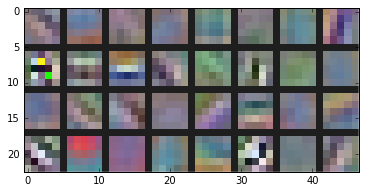

In [5]:
conv1_W = my_net.conv1.params['W'].eval()
conv1_W.shape
conv1_filters = tilePatches(np.reshape(conv1_W, [5, 5, 3, -1]), ncol=8)
print(np.max(conv1_filters), np.min(conv1_filters))
plt.imshow(2*conv1_filters+0.5, interpolation='none')
plt.show()

## Compute the size of a map

In [35]:
def mapSize(input_sz, filter_size, stride=1, padding=0):
    return np.int32((input_sz + padding - filter_size)/stride + 1)

input_map = np.asarray([32, 32])
conv1_fz = np.asarray(my_net.conv1.shape[0:2])
conv1_map = mapSize(input_map, conv1_fz, padding=(conv1_fz-1))
print(conv1_map)

pool1_fz = np.asarray(my_net.pool1.shape[1:3])
pool1_map = mapSize(conv1_map, pool1_fz, stride=my_net.pool1.stride[1:3])
print(pool1_map)


conv2_fz = np.asarray(my_net.conv2.shape[0:2])
conv2_map = mapSize(pool1_map, conv2_fz, padding=(conv2_fz-1))
print(conv2_map)

pool2_fz = np.asarray(my_net.pool2.shape[1:3])
pool2_map = mapSize(conv2_map, pool2_fz, stride=my_net.pool2.stride[1:3])
print(pool2_map)


conv3_fz = np.asarray(my_net.conv3.shape[0:2])
conv3_map = mapSize(pool2_map, conv3_fz, padding=(conv3_fz-1))
print(conv3_map)

pool3_fz = np.asarray(my_net.pool3.shape[1:3])
pool3_map = mapSize(conv3_map, pool3_fz, stride=my_net.pool3.stride[1:3])
print(pool3_map)

[32 32]
[15 15]
[15 15]
[7 7]
[7 7]
[3 3]


## Computing receptive field size

In [66]:
def rfSize(out_filter_size, in_filter_size, in_stride=1):
    return (out_filter_size-1)*in_stride + in_filter_size

conv1_rf = rfSize(conv1_fz, np.asarray([1,1]))
print("conv1 rf size")
print(conv1_rf)

pool1_rf = rfSize(pool1_fz, conv1_fz)
print("pool1 rf size")
print(pool1_rf)

pool1_stride = my_net.pool1.stride[1:3]
conv2_rf = rfSize(conv2_fz, pool1_rf, in_stride=pool1_stride)
print("conv2 rf size")
print(conv2_rf)

pool2_rf = rfSize(pool2_fz, conv2_rf)
print("pool2 rf size")
print(pool2_rf)

pool2_stride = my_net.pool2.stride[1:3]
conv3_rf = rfSize(conv3_fz, pool2_rf, in_stride=pool2_stride)
print("conv3 rf size")
print(conv3_rf)

pool3_rf = rfSize(pool3_fz, conv3_rf)
print("pool3 rf size")
print(pool3_rf)

pool3_stride = my_net.pool3.stride[1:3]
fc4_fz = np.asarray([3, 3])
fc4_rf = rfSize(fc4_fz, pool3_rf, in_stride=pool3_stride)
print("fc4 rf size")
print(fc4_rf)


conv1 rf size
[5 5]
pool1 rf size
[7 7]
conv2 rf size
[15 15]
pool2 rf size
[17 17]
conv3 rf size
[25 25]
pool3 rf size
[27 27]
fc4 rf size
[31 31]


In [69]:
## Visualize second layer units
stimuli_x = tf.placeholder
unit_idx = 0

class CifarV2Net():
    def __init__(self):
        self.conv1 = ConvLayer((5, 5, 3, 32), 1,'relu', stddev=0.0001, bias=0.0)
        self.pool1 = PoolLayer((3, 3), 2,'MAX', 'VALID')
        self.conv2 = ConvLayer((5, 5, 32, 32), 1,'relu', stddev=0.01, bias=0.0)
        
        
    def forward(self, X):
        conv1 = self.conv1.forward(X)
        pool1 = self.pool1.forward(conv1)
        conv2 = self.conv2.forward(pool1)
        return conv2

my_v2net = CifarV2Net()
## use learned parameters to visualize units
my_v2net.conv1.params['W'] = my_net.conv1.params['W']
my_v2net.conv1.params['b'] = my_net.conv1.params['b']
my_v2net.conv2.params['W'] = my_net.conv2.params['W']
my_v2net.conv2.params['b'] = my_net.conv2.params['b']

vis_cost = tf.reduce_mean(tf.square(my_v2net.forward(stimuli_x)[:,0,0,unit_idx]))
train_stimuli_update = tf.train.GradientDescentOptimizer(0.1).compute_gradients(vis_cost, var_list=[stimuli])



In [ ]:
stimuli = np.random.normal(size=[1, conv2_rf[0], conv2_rf[1], 3])
for i in range(10000):
    ## display training accuracy 
    sess.run(train_stimuli_update, feed_dict={x: stimuli})